#### **Import Libraries**

In [22]:
from pathlib import Path
import os 
import jax 
import jax.numpy as jnp 
from functools import partial

#### **Set Up Data Paths**

In [23]:
github_folder = str(Path(os.getcwd()).parent.parent.parent.absolute())
paper_link = github_folder + "/rfp_paper/figures/simulations/ols/"
print(github_folder, paper_link)

/Users/patrickpower/Documents/GitHub /Users/patrickpower/Documents/GitHub/rfp_paper/figures/simulations/ols/


#### **Set Up Plotting**

In [24]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-dark-palette')

from matplotlib import font_manager 
locations = github_folder + '/rfp/styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

/Users/patrickpower/Documents/GitHub/rfp/styles/Newsreader
/Users/patrickpower/Documents/GitHub/rfp/styles/Newsreader/static/Newsreader_60pt/Newsreader_60pt-ExtraLight.ttf


/var/folders/yl/r206rt_11977v3zys5vb9ffw0000gn/T/ipykernel_18794/357715028.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


#### **Utility Functions**

In [25]:
def cef(x):
  """Conditional Expectation Function"""
  return x**3                                                                                 # x**3 is the CEF

def sample(key):
  """Sample from the data generating process"""
  subkey1, subkey2, subkey3 = jax.random.split(key, 3)                                        # Split key          
  x = jax.random.uniform(subkey1, minval=-3., maxval=3.)                                      # Covariate
  d = jax.random.bernoulli(subkey2, jax.nn.sigmoid(x))                                        # Treatment
  y = x**3  + 0.2*jax.random.normal(subkey3)                                                  # Outcome
  return y, x, d                                                                              # Return outcome, covariate, treatment

@partial(jax.jit, static_argnums=(0,))
def estimate_ols(n, key):
  """Estimate the Average Treatment Effect using OLS"""
  ys, xs, ds = jax.vmap(sample)(jax.random.split(key, n))                                     # Batch of `n` samples
  ys, xs, ds = jnp.reshape(ys, (-1,1)), jnp.reshape(xs, (-1,1)), jnp.reshape(ds, (-1,1))      # Reshape to 2D
  regs = jnp.hstack((ds, jnp.ones_like(ds), xs))                                              # Regressors
  coef = jnp.linalg.lstsq(regs, ys)[0][0]                                                     # OLS, y outcome          
  return coef                                                                                 # Return coefficient  

@partial(jax.jit, static_argnums=(0,))
def estimate_prop_score(n, key): 
  """Estimate the Average Treatment Effect using OLS"""
  ys, xs, ds = jax.vmap(sample)(jax.random.split(key, n))                                     # Batch of `n` samples
  ys, xs, ds = jnp.reshape(ys, (-1,1)), jnp.reshape(xs, (-1,1)), jnp.reshape(ds, (-1,1))      # Reshape to 2D
  regs = jnp.hstack((jnp.ones_like(ds), xs))                                                  # Regressors
  coeffs = jnp.linalg.lstsq(regs, ds)[0]                                                      # OLS, d treatment
  est_prop_score = jnp.clip(regs @ coeffs, 0.05, 0.95)                                                             # Estimated propensity score
  scaled_outcome1 = (ys / est_prop_score)                                                     # Scaled outcome
  scaled_outcome0 = (ys / (1 - est_prop_score))                                               # Scaled outcome
  y1 = jnp.mean(scaled_outcome1, where=ds==1)                                                       # Average outcome for treated
  y0 =jnp.mean(scaled_outcome0, where=ds==0)                                                       # Average outcome for untreated
  ate = y1 - y0                                                                               # Average treatment effect
  return ate                                                                                  # Return ate


##### **Simulate**

In [26]:
n = 500 

estimates_ols = jax.vmap(partial(estimate_ols, n))(jax.random.split(jax.random.PRNGKey(0), 20000)).reshape(-1,)
normalized_estimates_ols = estimates_ols/jnp.std(estimates_ols)

estimates_prop_score = jax.vmap(partial(estimate_prop_score, n))(jax.random.split(jax.random.PRNGKey(0), 20000)).reshape(-1,)
normalized_estimates_prop_score = estimates_prop_score/jnp.std(estimates_prop_score)

/Users/patrickpower/.pyenv/versions/rfp_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


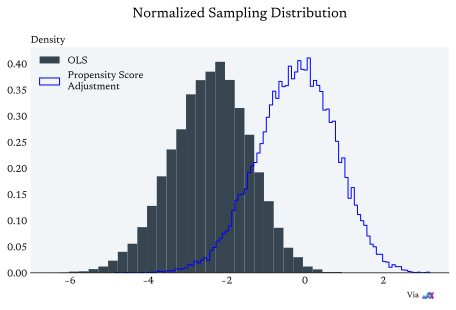

In [27]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)
for key in 'left', 'right', 'top':
  ax.spines[key].set_visible(False)
ax.set_title('Normalized Sampling Distribution', size=14, loc='center', pad=30)
subtitle = 'Density'
ax.text(0., 1.02, s=subtitle, transform=ax.transAxes)
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(length=0)
#ax.yaxis.grid(True, color='white', linewidth=2)
ax.hist(normalized_estimates_ols, color='#36454F', bins=30, density=True, label='OLS')
ax.hist(normalized_estimates_prop_score, alpha=1.0, color='blue', density=True, histtype='step', bins=100, label='Propensity Score\nAdjustment')
# load the image
img_path = github_folder + '/rfp/jax_img.png'
img = plt.imread(img_path)

# create an OffsetImage object with the image
imagebox = OffsetImage(img, zoom=0.04)

# create the annotation with the OffsetImage object
xy = (0.95, - 0.1)
text = 'Via'
ann = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')

# add the annotation to the axis
ax.add_artist(ann)

# set the text for the annotation
ax.annotate(text, xy=(0.9, -0.1), xycoords='axes fraction',
            fontsize=8, color='black', ha='left', va='center')
#fig.savefig(paper_link + 'hist_case_length.png', format='png')
plt.legend(frameon=False, loc='upper left')
fig.savefig(paper_link + 'motivation1.png', format='png')
plt.show()